 ╔══<i><b>&nbsp;Alai-DeepLearning&nbsp;</b></i>══════════════════════════════════╗
###  &nbsp;&nbsp; **✎&nbsp;&nbsp;Week 5. machine learning basis**
# Homework 2. Multi classification

### _Objective_
Tensorflow 을 이용해서 One Vs All 전략을 이용해 다중 classification 모델을 생성합니다.

아래 순서에 맞게 프로그램을 작성해 주세요.
1. Setosa  Vs Versicolour, Virginica 모델 구현
 - 학습시 Tensorboard 을 이용해 loss 와 accuracy 을 추적해 주세요. 
 - 학습 동안 acc 가 가장 높은 모델을 저장해 주세요.
2. Versicolour Vs Setosa, Virginica 모델 구현
  - 학습시 Tensorboard 을 이용해 loss 와 accuracy 을 추적해 주세요. 
 - 학습 동안 acc 가 가장 높은 모델을 저장해 주세요.
3. Virginica Vs Setosa, Versicolour 모델 구현
  - 학습시 Tensorboard 을 이용해 loss 와 accuracy 을 추적해 주세요. 
 - 학습 동안 acc 가 가장 높은 모델을 저장해 주세요.
4. 저장된 3개의 모델을 불러온 후 가장 높은 확률이 나오는 값을 선택합니다. <br>
가령 아래의 경우 **Versicolour** 을 선택합니다.

| class        | probabilty |
|--------------|------------|
| Setosa       | 0.7        |
| Versicolour  | 0.9        |
| Virginica    | 0.3        |

학습이 끝난후 모든 데이터를 평가한 후 accuracy 을 측정합니다.

╚═══════════════════════════════════════════════╝

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.datasets import load_iris

In [0]:
class dataFrame() :
    def __init__(self) :
        np.random.seed(1)
        iris = load_iris()
        xs = iris['data']
        ys = iris['target']
        ys_name = iris['target_names']
        
        concat = np.concatenate([xs, np.reshape(ys, [-1, 1])], axis=1)
        column = ["sepal_length", "sepal_width", "petal_length", "petal_width", "target"]
        df = pd.DataFrame(concat, columns=column) 
        
        # normalization
        temp = df.loc[:,"sepal_length":"petal_width"]
        df.loc[:,"sepal_length":"petal_width"] = (temp - temp.min()) / (temp.max() - temp.min())
        
        self.xs = df.loc[:,"sepal_length":"petal_width"].values
        self.ys = df.loc[:,"target"].values
        self.ys = self.ys.reshape([-1, 1])

In [0]:
class Classifier(dataFrame) : # dataFrame 상속받음.
    def __init__(self, sess, one):  
        super().__init__()
        self.sess = sess
        
        with tf.name_scope('variables_initial') :
            # target을 받아서 label을 치환한다. (1vs 2,3)    
            mask_ys_label = tf.equal(self.ys, (tf.ones_like(self.ys, dtype=tf.float64) * one)) # mask_ys_label.shape = (150, )
            self.ys_label = tf.cast(mask_ys_label, tf.float64) 
            self.xs = self.xs # dataFrame에서 상속받은 x
            
            # # ys 수정, 정답: 1, 오답: 0
            # target_indices = np.where(ys == self.target_index)
            # self.ys[target_indices] = 1
            # other_indices = np.where(ys != self.target_index)
            # self.ys[other_indices] = 0
        
            # variable initialize
            num_in = 4
            num_out = 100
            self.weights1 = tf.Variable(np.random.normal(loc=0.0, scale=0.1, size=(num_in, num_out)), dtype=tf.float64, name='weights1')
            self.bias1 = tf.Variable(np.random.normal(loc=0.0, scale=0.1, size=(num_out)), dtype=tf.float64, name='bias1')
            
            num_in = num_out
            num_out = 1                
            self.weights2 = tf.Variable(np.random.normal(loc=0.0, scale=0.1, size=(num_in, num_out)), dtype=tf.float64, name='weights2')
            self.bias2 = tf.Variable(np.random.normal(loc=0.0, scale=0.1, size=(num_out)), dtype=tf.float64, name='bias2')
            
            # 필요한 변수 선언.
            self.acc = tf.Variable(-10, dtype = tf.float64)
            
        with tf.name_scope('graph_initial') :
            self.sess.run(tf.global_variables_initializer())
        
    def train(self, learning_rate = 0.01) :
        z_1 = tf.matmul(self.xs, self.weights1) + self.bias1
        a_1 = tf.nn.relu(z_1)
            
        z_2 = tf.matmul(a_1, self.weights2) + self.bias2
        a_2 = tf.nn.sigmoid(z_2)

        a_2_ = tf.round(a_2) # a_2  0, 1 로 변환
        
        cal_acc = tf.math.reduce_mean(tf.cast(tf.equal(a_2_, self.ys_label), tf.float64))
        update_acc = tf.assign(ref = self.acc, value = cal_acc)
        
        # self.ys = tf.reshape(self.ys, [-1, 1])
        loss = tf.nn.sigmoid_cross_entropy_with_logits(logits= a_2, labels= self.ys_label)

        optimize = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)
    
        _, acc = self.sess.run([optimize, update_acc])
                                     
        return acc

In [0]:
class OVA() :
    def __init__(self, df) :
        self.df = df
        sess = tf.Session()
        self.c1 = Classifier(sess, 0)
        self.c2 = Classifier(sess, 1)
        self.c3 = Classifier(sess, 2)
        
        self.acc_list1 = []
        self.acc_list2 = []
        self.acc_list3 = []
        
        self.iteration = 0
        
    def train_all(self, learning_rate=0.01, iteration=1) :
        self.iteration = iteration

        for i in range(iteration) :
            acc1 = self.c1.train(learning_rate)
            acc2 = self.c2.train(learning_rate)
            acc3 = self.c3.train(learning_rate)
            self.acc_list1.append(acc1)
            self.acc_list2.append(acc2)
            self.acc_list3.append(acc3)
        
    def show_result(self) :
        
        fig = plt.figure(figsize=(15, 15))
        
        ax = fig.add_subplot(5,5,1)
        ax.plot(np.arange(0, self.iteration, 1), self.acc_list1, label="accuracy", color='blue')
        ax.legend()
        ax.set_ylim(0, 1.5)
        ax.set_title("Setosa")
        
        ax = fig.add_subplot(5,5,2)
        ax.plot(np.arange(0, self.iteration, 1), self.acc_list2, label="accuracy", color='blue')
        ax.legend()
        ax.set_ylim(0, 1.5)
        ax.set_title("Versicolour")
    
        ax = fig.add_subplot(5,5,3)
        ax.plot(np.arange(0, self.iteration, 1), self.acc_list3, label="accuracy", color='blue')
        ax.legend()
        ax.set_ylim(0, 1.5)
        ax.set_title("Virginica")
        
        plt.show()

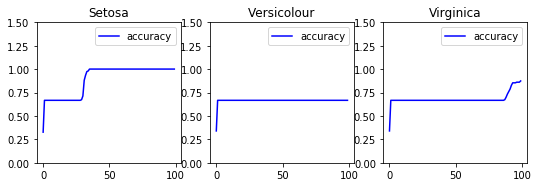

In [7]:
def main() :
    df = dataFrame()   
    ova = OVA(df)
    ova.train_all(learning_rate=0.01, iteration=100)
    ova.show_result()
    
if __name__ == '__main__':
    main()           

#  

---

    Copyright(c) 2019 by Public AI. All rights reserved.
    Writen by PAI, SangJae Kang ( rocketgrowthsj@publicai.co.kr )  last updated on 2019/03/22

---